In [49]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from IPython.display import clear_output
import pandas as pd
import scipy.stats as stats
import seaborn as sns

In [23]:
import pandas as pd

# Importing original dataset via CSV
def load_dataset(csv):
    df = pd.read_csv(csv)
    return df

csv = 'Datasets/online_shoppers_intention.csv'
df = load_dataset(csv)

# Removing Outliers of excessively high session duration
def remove_outliers_iqr(df):
    # Ensure that 'SessionDuration' is a numeric column
    df['SessionDuration'] = pd.to_numeric(df['SessionDuration'], errors='coerce')
    
    # Calculate Q1 (25th percentile) and Q3 (75th percentile)
    Q1 = df['SessionDuration'].quantile(0.25)
    Q3 = df['SessionDuration'].quantile(0.75)
    IQR = Q3 - Q1
    upper_bound = Q3 + 2.5 * IQR
    df_no_outliers = df[df['SessionDuration'] < upper_bound].dropna()
    return df_no_outliers

# Remove columns that are not needed
del df['Month']
del df['OperatingSystems']
del df['Browser']
del df['Region']
del df['TrafficType']

# Create new columns for session duration and total pages viewed
sessions = df
sessions['SessionDuration'] = sessions['Administrative_Duration'] + sessions['Informational_Duration'] + sessions['ProductRelated_Duration']
sessions['TotalPagesViewed'] = sessions['Administrative'] + sessions['Informational'] + sessions['ProductRelated']

# Remove outliers from the dataset
sessions = remove_outliers_iqr(sessions)

#
sessions.loc[sessions['VisitorType'] == 'Returning_Visitor', 'VisitorType'] = 1
sessions.loc[sessions['VisitorType'] == 'New_Visitor', 'VisitorType'] = 2
sessions = sessions[sessions['VisitorType'] != 'Other']

#
sessions['Revenue'] = sessions['Revenue'].astype(int)#converting revenue into 0 and 1

# Display the top rows and the count of revenue = 1
print(sessions.head())
print((sessions['Revenue'] == 1).sum())


   Administrative  Administrative_Duration  Informational  \
0               0                      0.0              0   
1               0                      0.0              0   
2               0                      0.0              0   
3               0                      0.0              0   
4               0                      0.0              0   

   Informational_Duration  ProductRelated  ProductRelated_Duration  \
0                     0.0               1                 0.000000   
1                     0.0               2                64.000000   
2                     0.0               1                 0.000000   
3                     0.0               2                 2.666667   
4                     0.0              10               627.500000   

   BounceRates  ExitRates  PageValues  SpecialDay VisitorType  Weekend  \
0         0.20       0.20         0.0         0.0           1    False   
1         0.00       0.10         0.0         0.0           1   

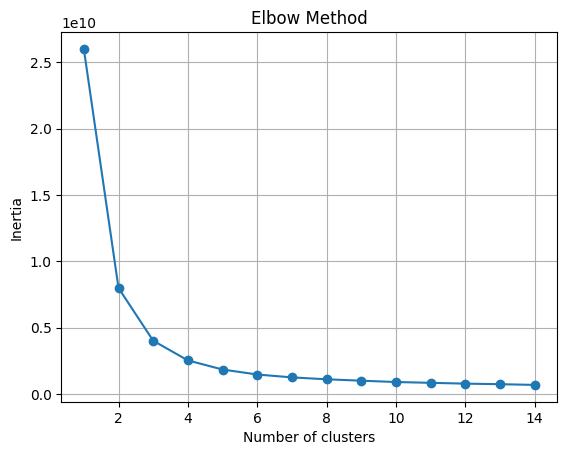

In [24]:
#How many K Means we should use with Elbow Method
from sklearn.cluster import KMeans
def elbow_method(data, max_k):
  inertias = []
  for i in range(1, max_k):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(data)
    inertias.append(kmeans.inertia_)
  
  plt.plot(range(1, max_k), inertias, 'o-')
  plt.title('Elbow Method')
  plt.xlabel('Number of clusters')
  plt.ylabel('Inertia')
  plt.grid(True)
  plt.show()

elbow_method(sessions, 15)

In [26]:
# Performing KMeans clustering
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=6, random_state=42)
kmeans.fit(sessions)

sk_centroids = kmeans.cluster_centers_  # Cluster centroids
sk_labels = kmeans.labels_  # Cluster labels for each data point

#Adding clusters to sessions
sessions['Cluster'] = sk_labels

# Display centroids and sample data points
centroid_df = pd.DataFrame(sk_centroids, columns=sessions.columns[:])  # Adjust for the added 'Cluster' column
print("Centroids Overview:\n", centroid_df)


Centroids Overview:
    Administrative  Administrative_Duration  Informational  \
0        4.689805               168.150709       1.312364   
1        2.080460                64.486591       0.355625   
2        4.213245               155.958272       1.125828   
3        0.886706                22.160625       0.100851   
4        3.710191               153.770117       0.897293   
5        2.758091                97.271403       0.549095   

   Informational_Duration  ProductRelated  ProductRelated_Duration  \
0               91.068085       95.210412              4011.264950   
1               18.065634       20.783002               598.860451   
2               84.562705       66.600000              2779.109868   
3                3.035995        7.234228               137.090423   
4               69.340022       46.000000              1861.663978   
5               31.616969       33.337356              1173.333477   

   BounceRates  ExitRates  PageValues  SpecialDay  VisitorTy

In [27]:
#USING ANOVA to see statistical difference between the means of each feature across the clusters
results = {}
num_clusters = len(set(sk_labels))  # Get the number of unique clusters in `sk_labels`
for feature in sessions.columns:
    if feature != 'labels':
        feature_data = [sessions[sk_labels == i][feature] for i in range(num_clusters) if len(sessions[sk_labels == i]) > 0]
        if all(len(data) > 1 for data in feature_data) and len(feature_data) > 1:
            # Perform ANOVA for the current feature across all centroids (clusters)
            stat, p_value = stats.f_oneway(*feature_data)
            # Store the p-value in the results dictionary
            results[feature] = p_value
        else:
            print(f"Not enough data for ANOVA in feature '{feature}'")

# Initialize a dictionary to store only the significant features
significant_features = {feature: p_value for feature, p_value in results.items() if p_value < 0.05}

# Print the significant features
print("Significant Features:", significant_features)

Significant Features: {'Administrative': 0.0, 'Administrative_Duration': 1.5891338574269885e-295, 'Informational': 3.367475780322782e-272, 'Informational_Duration': 4.757222711275464e-159, 'ProductRelated': 0.0, 'ProductRelated_Duration': 0.0, 'BounceRates': 0.0, 'ExitRates': 0.0, 'PageValues': 7.167964471594895e-73, 'SpecialDay': 0.00044764529989847084, 'VisitorType': 6.215119435071629e-43, 'Weekend': 0.009354349935038449, 'Revenue': 1.0328700618534981e-101, 'SessionDuration': 0.0, 'TotalPagesViewed': 0.0, 'Cluster': 0.0}


C:\Users\Owner\AppData\Roaming\Python\Python312\site-packages\scipy\stats\_axis_nan_policy.py:531: ConstantInputWarning: Each of the input arrays is constant; the F statistic is not defined or infinite
  res = hypotest_fun_out(*samples, **kwds)


In [28]:
centroid_df

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,VisitorType,Weekend,Revenue,SessionDuration,TotalPagesViewed,Cluster
0,4.689805,168.150709,1.312364,91.068085,95.210412,4011.264950,0.006941,0.021635,8.789025,0.050325,1.030369,0.216920,0.273319,4270.483744,101.212581,0.008677
1,2.080460,64.486591,0.355625,18.065634,20.783002,598.860451,0.009023,0.026761,7.129150,0.061512,1.189481,0.243121,0.174504,681.412676,23.219087,1.000000
2,4.213245,155.958272,1.125828,84.562705,66.600000,2779.109868,0.007090,0.021294,8.205168,0.049801,1.055629,0.237086,0.234437,3019.630845,71.939073,2.002649
3,0.886706,22.160625,0.100851,3.035995,7.234228,137.090423,0.044866,0.073591,2.022635,0.072866,1.163720,0.217420,0.062650,162.287042,8.221786,3.000000
4,3.710191,153.770117,0.897293,69.340022,46.000000,1861.663978,0.008590,0.024062,8.365718,0.053503,1.077229,0.238854,0.191083,2084.774117,50.607484,4.000796
5,2.758091,97.271403,0.549095,31.616969,33.337356,1173.333477,0.009031,0.024915,9.622942,0.054526,1.132748,0.258365,0.216676,1302.221848,36.644542,4.997806


In [30]:
from sklearn.metrics import pairwise_distances

# Assuming 'data' is the original dataset and 'cluster_labels' are the labels
def compute_cohesion(sessions, centroids, cluster_labels):
    cohesion = []
    for cluster_id in centroids.index:
        cluster_data = sessions[cluster_labels == cluster_id]
        centroid = centroids.loc[cluster_id].values
        distances = pairwise_distances(cluster_data, [centroid])
        cohesion.append(distances.mean())
    return cohesion

# Example usage
cohesion_values = compute_cohesion(sessions, centroid_df, cluster_labels)


NameError: name 'cluster_labels' is not defined

In [31]:
from sklearn.metrics.pairwise import euclidean_distances

# Compute pairwise distances between centroids
centroid_distances = euclidean_distances(centroid_df.iloc[:, :-1])
centroid_distances


array([[   0.        , 4955.16338232, 1756.33316775, 5650.84241887,
        3066.55730114, 4108.6487281 ],
       [4955.16338232,    0.        , 3199.69058066,  696.54607331,
        1891.05452278,  846.77408107],
       [1756.33316775, 3199.69058066,    0.        , 3895.74939464,
        1310.25963454, 2353.00137141],
       [5650.84241887,  696.54607331, 3895.74939464,    0.        ,
        2587.50381409, 1543.13325908],
       [3066.55730114, 1891.05452278, 1310.25963454, 2587.50381409,
           0.        , 1044.58603531],
       [4108.6487281 ,  846.77408107, 2353.00137141, 1543.13325908,
        1044.58603531,    0.        ]])

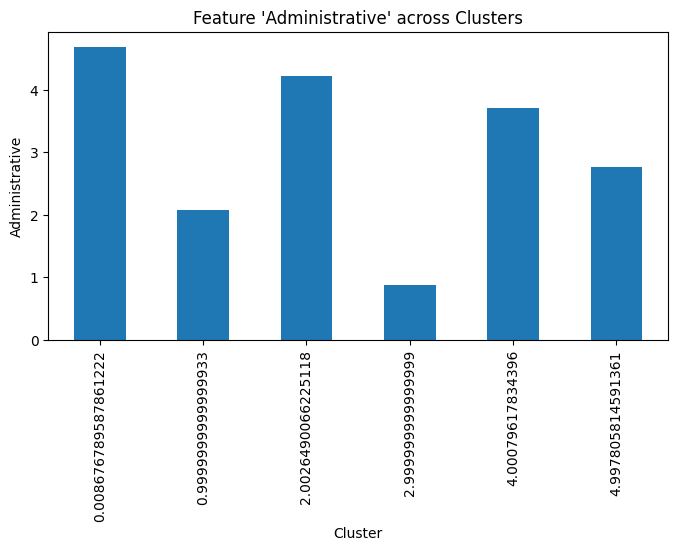

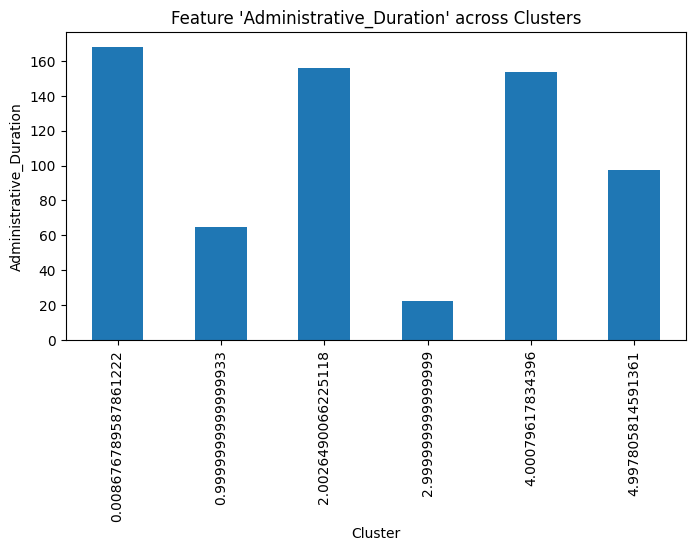

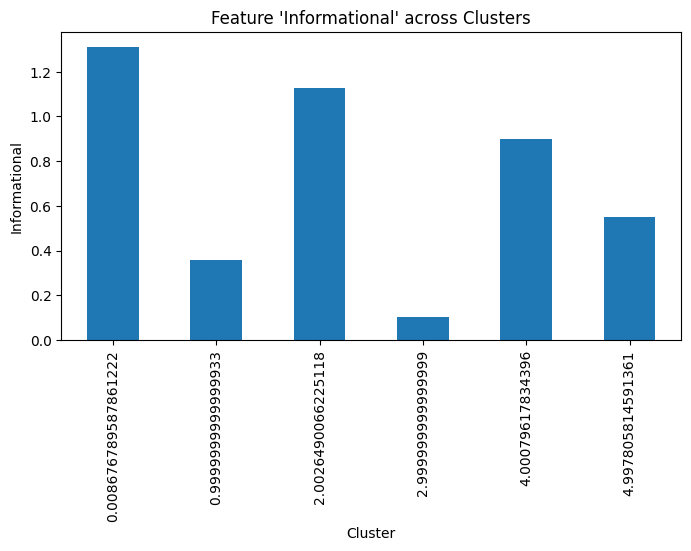

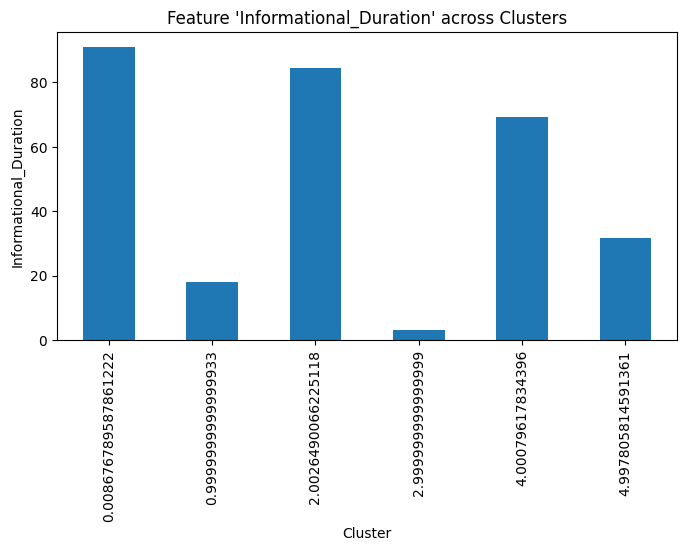

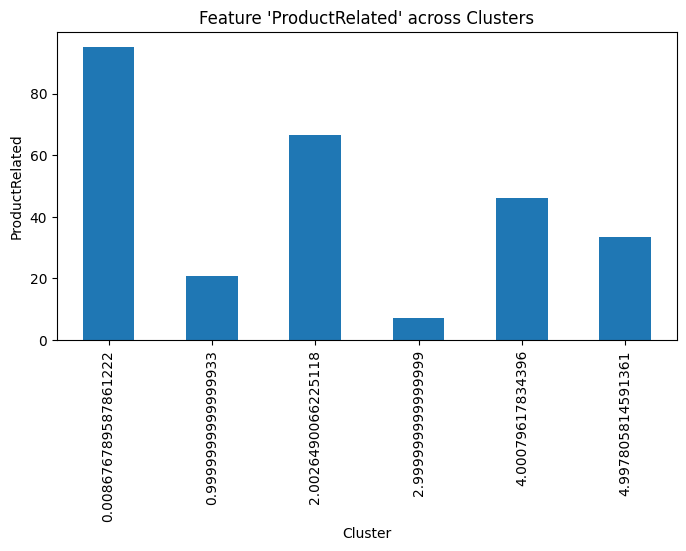

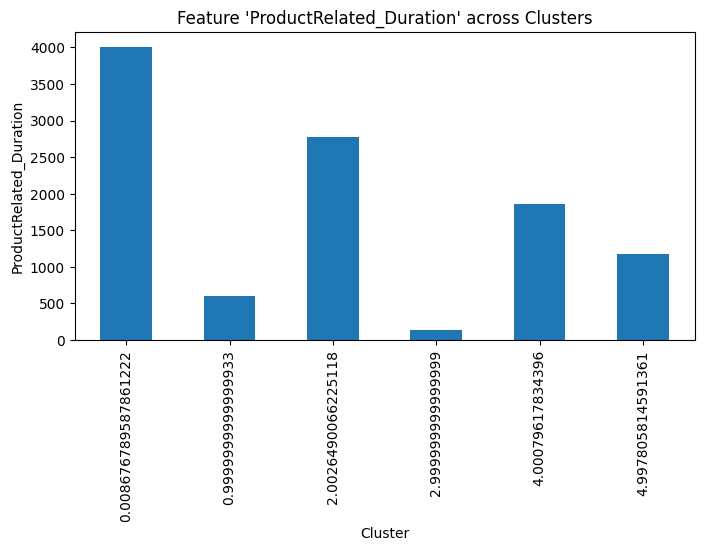

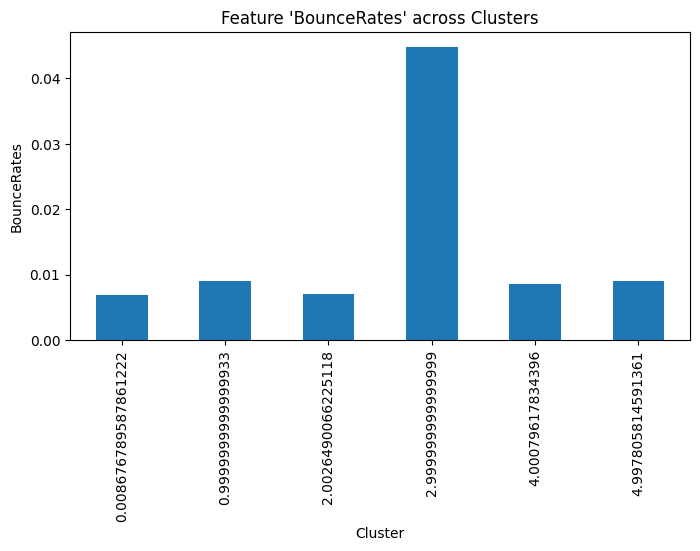

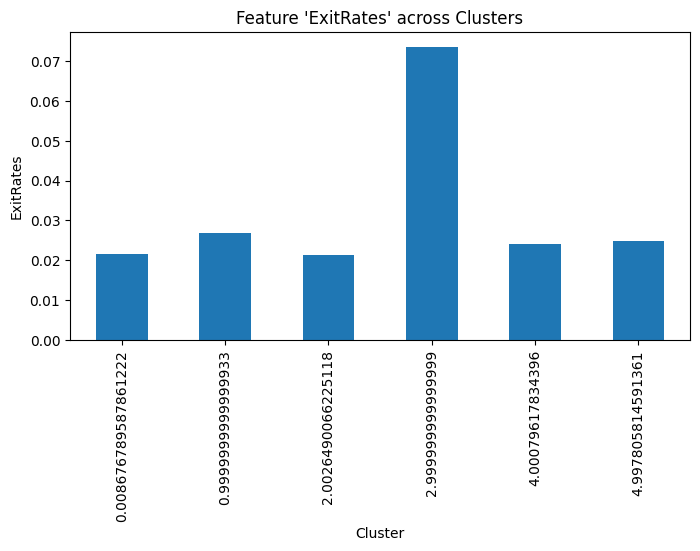

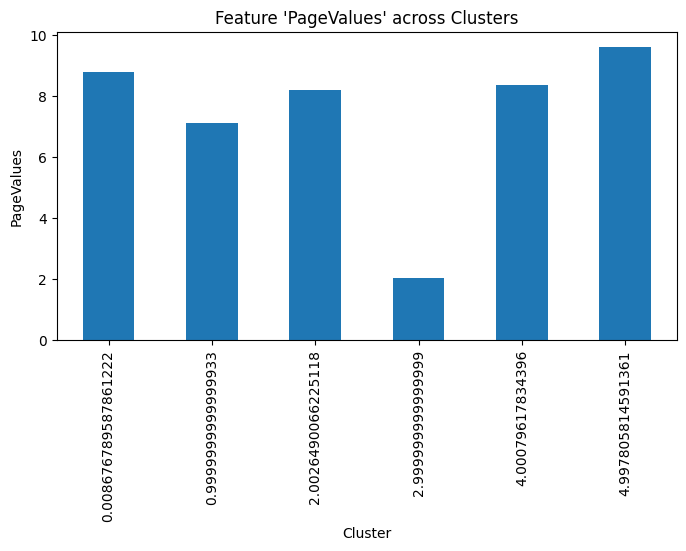

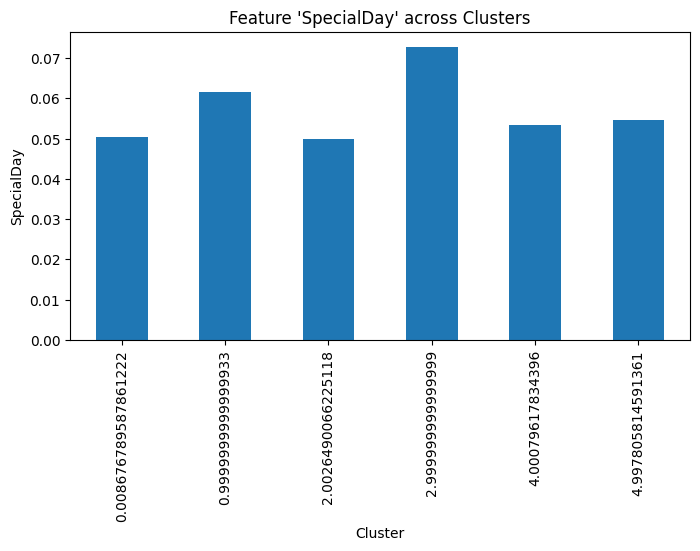

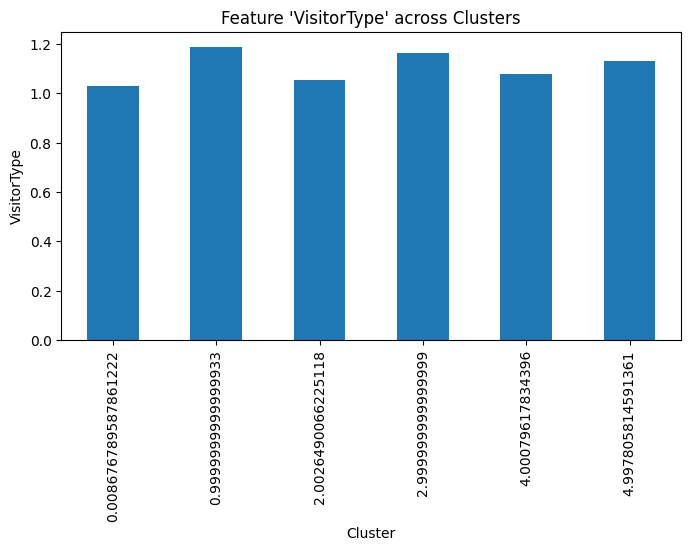

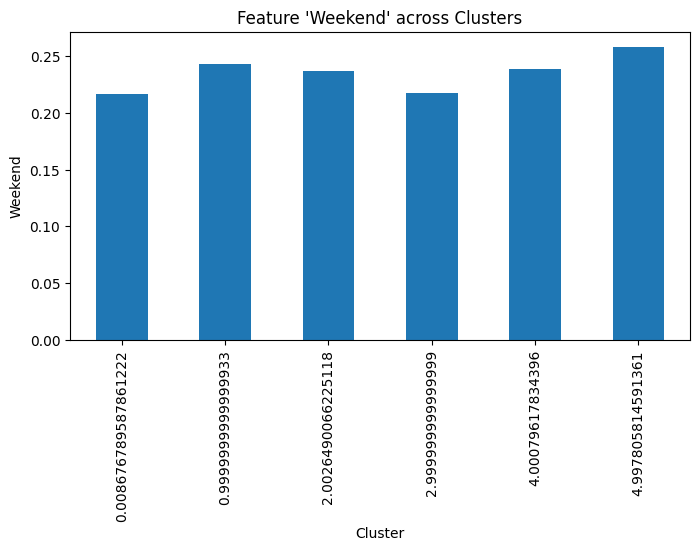

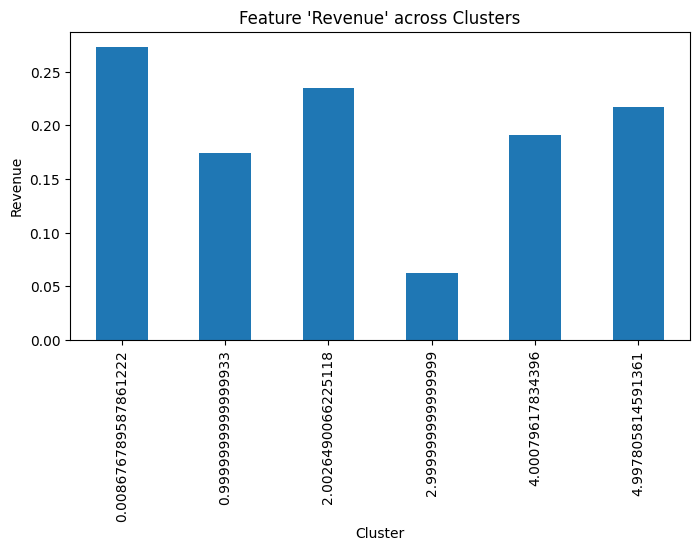

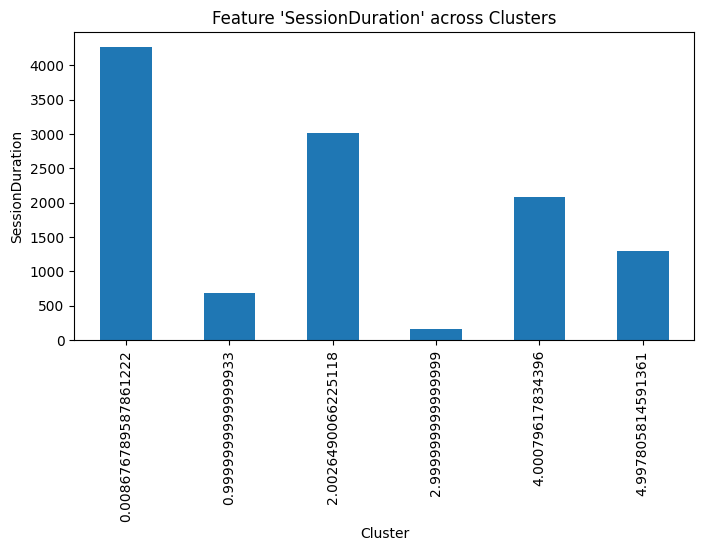

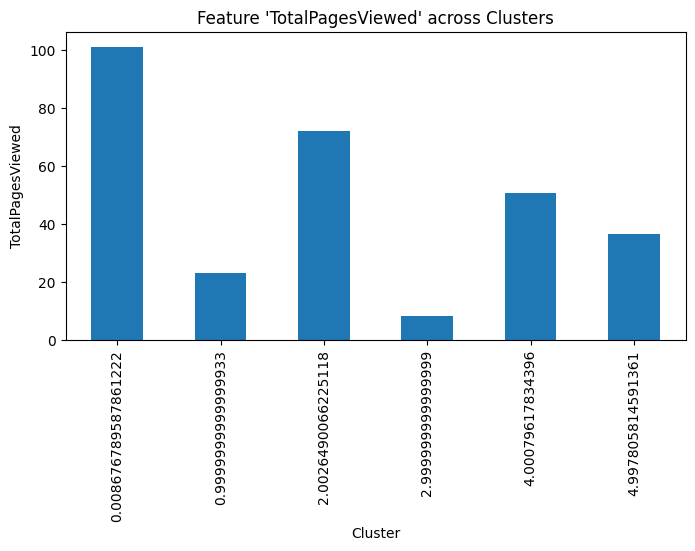

In [32]:
import matplotlib.pyplot as plt

# Plot feature values for each cluster
features = centroid_df.columns[:-1]  # Exclude 'Cluster'
for feature in features:
    plt.figure(figsize=(8, 4))
    centroid_df.set_index('Cluster')[feature].plot(kind='bar')
    plt.title(f"Feature '{feature}' across Clusters")
    plt.ylabel(feature)
    plt.xlabel('Cluster')
    plt.show()


Cluster 0 Summary:
       Administrative  Administrative_Duration  Informational  \
count      459.000000               459.000000     459.000000   
mean         4.697168               168.745955       1.311547   
std          4.641494               251.854371       1.896013   
min          0.000000                 0.000000       0.000000   
25%          1.000000                 6.500000       0.000000   
50%          4.000000                79.166667       0.000000   
75%          7.000000               205.640000       2.000000   
max         24.000000              1687.500000      14.000000   

       Informational_Duration  ProductRelated  ProductRelated_Duration  \
count              459.000000      459.000000               459.000000   
mean                90.388644       94.888889              4014.025086   
std                209.801786       43.277497               454.816305   
min                  0.000000       18.000000              2755.670940   
25%                  0.00

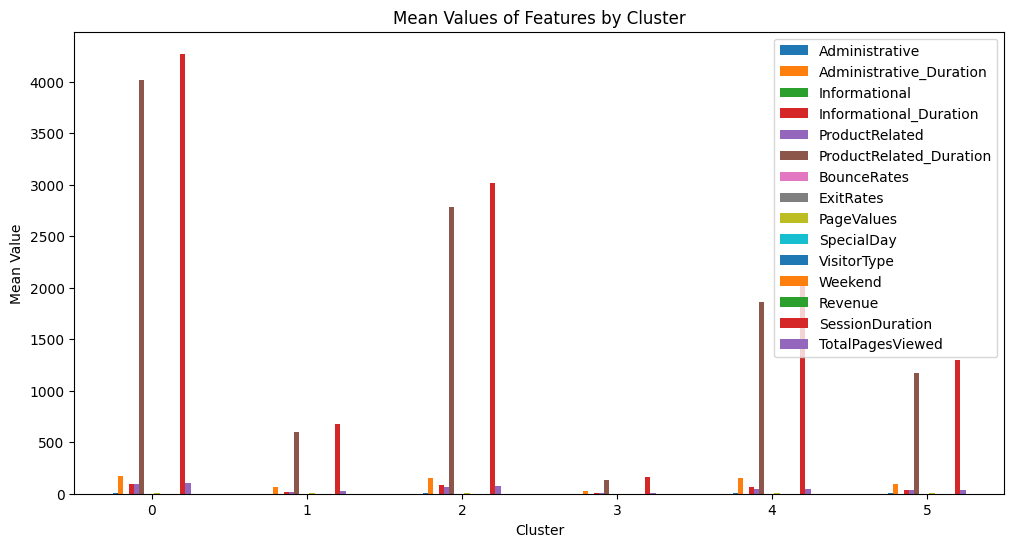

In [33]:
#Grouping the data by clusters for visualization
import matplotlib.pyplot as plt
grouped = sessions.groupby('Cluster')

# Calculate descriptive statistics for each cluster
cluster_summary = grouped.agg(['mean', 'median', 'std', 'min', 'max'])

# Display the summary statistics for each cluster
for cluster_id, cluster_data in grouped:
    print(f"Cluster {cluster_id} Summary:")
    print(cluster_data.describe())  # Summary of each cluster
    print("\n")

# Plot the mean value of each feature for each cluster
cluster_means = grouped.mean()
cluster_means.plot(kind='bar', figsize=(12, 6), title="Mean Values of Features by Cluster")
plt.ylabel("Mean Value")
plt.xlabel("Cluster")
plt.xticks(rotation=0)
plt.show()


In [ ]:
# Example of filtering sessions where 'Cluster' == 3
cluster_3_df = sessions[sessions['Cluster'] == 3]

# Descriptive analysis for numerical columns
summary_stats = cluster_3_df.describe()  # Basic statistics (mean, std, min, max, etc.)

# Count of each unique value in categorical columns (assuming 'VisitorType' and 'Revenue' are categorical)
visitor_type_count = cluster_3_df['VisitorType'].value_counts()
revenue_count = cluster_3_df['Revenue'].value_counts()

# Correlations between numerical features
correlations = cluster_3_df.corr()

# Print or save the results
print("Summary Statistics:\n", summary_stats)
print("\nVisitorType Counts:\n", visitor_type_count)
print("\nRevenue Counts:\n", revenue_count)
print("\nCorrelations:\n", correlations)

# If you want to store this in another DataFrame (which is already done with 'cluster_3_df')
# Example: Save descriptive statistics into a new DataFrame (for further use or export)
summary_stats_df = summary_stats.transpose()  # To transpose and make it more readable

# Optional: Export to CSV if needed

cluster_3_df.to_csv('Low_Revenue_Cluster.csv')


Summary Statistics:
        Administrative  Administrative_Duration  Informational  \
count     4581.000000              4581.000000    4581.000000   
mean         0.886706                22.160625       0.100851   
std          1.785201                52.688320       0.487263   
min          0.000000                 0.000000       0.000000   
25%          0.000000                 0.000000       0.000000   
50%          0.000000                 0.000000       0.000000   
75%          1.000000                14.000000       0.000000   
max         15.000000               539.500000       6.000000   

       Informational_Duration  ProductRelated  ProductRelated_Duration  \
count             4581.000000     4581.000000              4581.000000   
mean                 3.035995        7.234228               137.090423   
std                 22.112067        5.830122               114.612807   
min                  0.000000        0.000000                 0.000000   
25%                  0.

In [46]:
#cluster_3_df.head()
cluster_3_df.to_csv('Low_Revenue_Cluster.csv', index=False)

In [34]:
import numpy as np
import matplotlib.pyplot as plt

# Ensure no zero or negative values exist (log transformation requires positive values)
# Add a small constant to handle zero values
epsilon = 1e-6  # Small value to avoid log(0)
cluster_means_log = np.log(grouped.mean() + epsilon)

# Plot the log-transformed mean values
cluster_means_log.plot(kind='bar', figsize=(12, 6), title="Log-Transformed Mean Values of Features by Cluster")
plt.ylabel("Log-Transformed Mean Value")
plt.xlabel("Cluster")
plt.xticks(rotation=0)
plt.show()


TypeError: loop of ufunc does not support argument 0 of type float which has no callable log method

In [53]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA

# Step 1: Import the dataset
file_path = "Datasets/Created Clusters/High_Revenue_Cluster.csv"  # Replace with your CSV file path
data = pd.read_csv(file_path)

# Step 2: Preprocessing
# Assuming the dataset has the necessary features
features = [
    'Administrative', 'Administrative_Duration', 'Informational', 'Informational_Duration', 
    'ProductRelated', 'ProductRelated_Duration', 'BounceRates', 'ExitRates', 
    'PageValues', 'VisitorType', 'SpecialDay', 'Month', 'OperatingSystems', 
    'Browser', 'Region', 'TrafficType', 'Weekend', 'SessionDuration', 'TotalPagesViewed'
]

# Encode categorical variable VisitorType
if 'VisitorType' in data.columns:
    le = LabelEncoder()
    data['VisitorType'] = le.fit_transform(data['VisitorType'])

# Standardize features
scaler = StandardScaler()
data[features] = scaler.fit_transform(data[features])

# Step 3: Apply PCA
pca = PCA(n_components=2)  # Reduce to 2 components for visualization
X_pca = pca.fit_transform(data[features])

# Step 4: Examine PCA results
print("Explained Variance Ratio:")
print(pca.explained_variance_ratio_)

print("\nPrincipal Components:")
pca_components = pd.DataFrame(pca.components_, columns=features)
print(pca_components.T)  # Transposed for better readability

# Optional: Save PCA-transformed data
pca_transformed = pd.DataFrame(X_pca, columns=['PCA1', 'PCA2'])
pca_transformed.to_csv('high_revenue_pca_transformed.csv', index=False)


Explained Variance Ratio:
[0.24873934 0.10684899]

Principal Components:
                                0         1
Administrative           0.288377  0.019461
Administrative_Duration  0.211775  0.029396
Informational            0.255061  0.104064
Informational_Duration   0.219116  0.088974
ProductRelated           0.413490 -0.104949
ProductRelated_Duration  0.415909 -0.066644
BounceRates              0.007862  0.585122
ExitRates               -0.035051  0.606436
PageValues              -0.149724 -0.306926
VisitorType              0.143606  0.345844
SpecialDay               0.011173  0.102026
Month                    0.064244 -0.101449
OperatingSystems         0.024639  0.042816
Browser                 -0.010436 -0.050797
Region                  -0.031940 -0.018158
TrafficType              0.013749  0.049959
Weekend                 -0.006427 -0.025541
SessionDuration          0.430031 -0.052568
TotalPagesViewed         0.423665 -0.096203


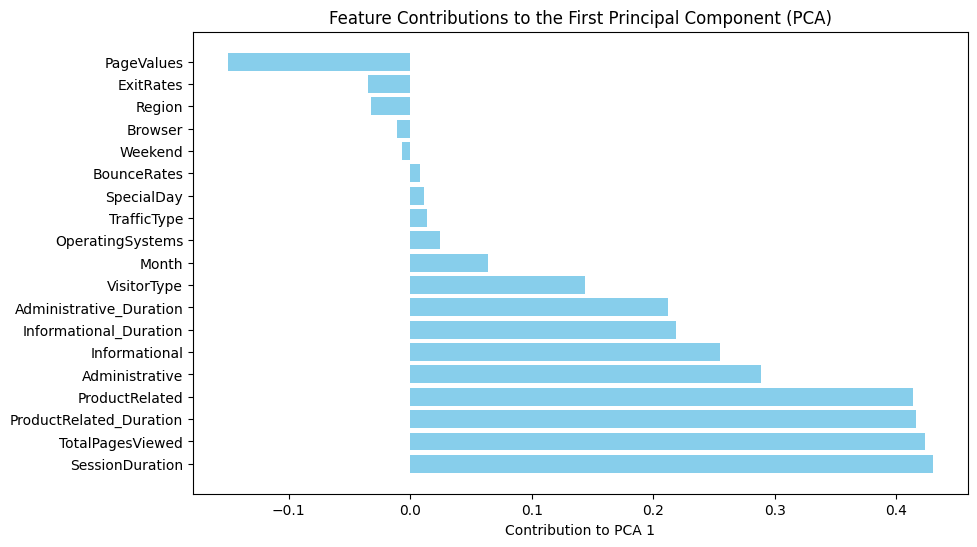

In [58]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Step 1: Import the dataset
file_path = "Datasets/Created Clusters/High_Revenue_Cluster.csv"  # Replace with your actual file path
data = pd.read_csv(file_path)

# Step 2: Preprocessing
# Assuming the dataset has the necessary features
features = ['Administrative', 'Administrative_Duration', 'Informational', 'Informational_Duration', 
            'ProductRelated', 'ProductRelated_Duration', 'BounceRates', 'ExitRates', 'PageValues', 
            'VisitorType', 'SpecialDay', 'Month', 'OperatingSystems', 'Browser', 'Region', 
            'TrafficType', 'Weekend', 'SessionDuration', 'TotalPagesViewed']

# Encode categorical variable VisitorType
data['VisitorType'] = data['VisitorType'].astype('category').cat.codes

# Standardize features
scaler = StandardScaler()
data[features] = scaler.fit_transform(data[features])

# Step 3: Apply PCA for dimensionality reduction to 1 component
pca = PCA(n_components=1)  # Reduce to 1 component
pca.fit(data[features])

# Step 4: Visualize feature contributions to the first principal component
# Get the loadings (contributions of each feature)
feature_contributions = pca.components_[0]  # First principal component

# Create a DataFrame with feature names and their contributions
contributions_df = pd.DataFrame({
    'Feature': features,
    'Contribution': feature_contributions
})

# Sort the contributions in descending order
contributions_df = contributions_df.sort_values(by='Contribution', ascending=False)

# Step 5: Plot the contributions
plt.figure(figsize=(10, 6))

# Bar plot of feature contributions to the first principal component
plt.barh(contributions_df['Feature'], contributions_df['Contribution'], color='skyblue')
plt.xlabel('Contribution to PCA 1')
plt.title('Feature Contributions to the First Principal Component (PCA)')

# Show plot
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Step 1: Import the dataset
file_path = "Datasets/Created Clusters/Low_Revenue_Cluster.csv"  # Replace with your actual file path
data = pd.read_csv(file_path)

# Step 2: Preprocessing
# Assuming the dataset has the necessary features
features = ['Administrative', 'Administrative_Duration', 'Informational', 'Informational_Duration', 
            'ProductRelated', 'ProductRelated_Duration', 'BounceRates', 'ExitRates', 'PageValues', 
            'VisitorType', 'SpecialDay', 'Weekend', 'SessionDuration', 'TotalPagesViewed']

# Encode categorical variable VisitorType
data['VisitorType'] = data['VisitorType'].astype('category').cat.codes

# Standardize features
scaler = StandardScaler()
data[features] = scaler.fit_transform(data[features])

# Step 3: Apply PCA for dimensionality reduction to 1 component
pca = PCA(n_components=1)  # Reduce to 1 component
pca.fit(data[features])

# Step 4: Visualize feature contributions to the first principal component
# Get the loadings (contributions of each feature)
feature_contributions = pca.components_[0]  # First principal component

# Create a DataFrame with feature names and their contributions
contributions_df = pd.DataFrame({
    'Feature': features,
    'Contribution': feature_contributions
})

# Sort the contributions in descending order
contributions_df = contributions_df.sort_values(by='Contribution', ascending=False)

# Step 5: Plot the contributions
plt.figure(figsize=(10, 6))

# Bar plot of feature contributions to the first principal component
plt.barh(contributions_df['Feature'], contributions_df['Contribution'], color='skyblue')
plt.xlabel('Contribution to PCA 1')
plt.title('Feature Contributions to the First Principal Component (PCA)')

# Show plot
plt.show()


KeyError: "['Month', 'OperatingSystems', 'Browser', 'Region', 'TrafficType'] not in index"

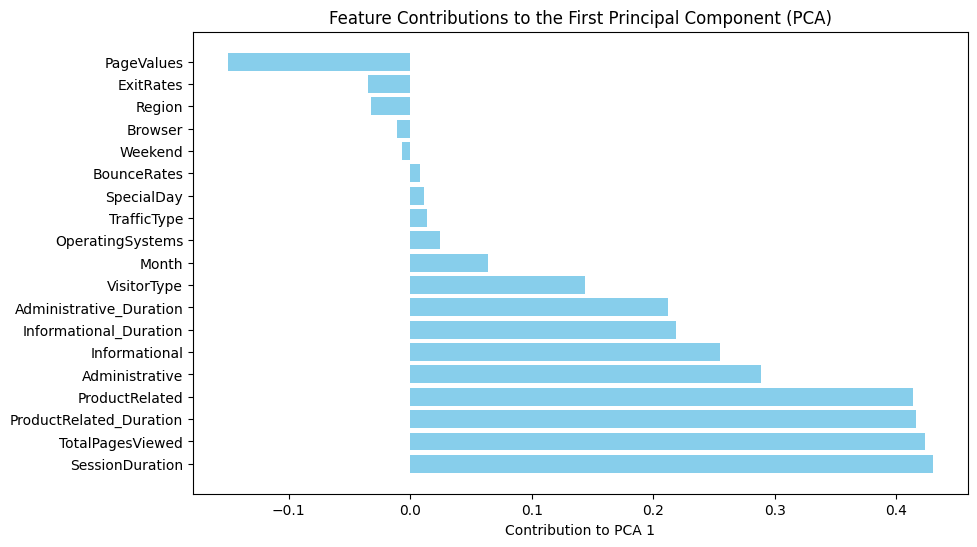

In [ ]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Step 1: Import the dataset
file_path = "Datasets/Created Clusters/High_Engagement_Cluster.csv"  # Replace with your actual file path
data = pd.read_csv(file_path)

# Step 2: Preprocessing
# Assuming the dataset has the necessary features
features = ['Administrative', 'Administrative_Duration', 'Informational', 'Informational_Duration', 
            'ProductRelated', 'ProductRelated_Duration', 'BounceRates', 'ExitRates', 'PageValues', 
            'VisitorType', 'SpecialDay', 'Month', 'OperatingSystems', 'Browser', 'Region', 
            'TrafficType', 'Weekend', 'SessionDuration', 'TotalPagesViewed']

# Encode categorical variable VisitorType
data['VisitorType'] = data['VisitorType'].astype('category').cat.codes

# Standardize features
scaler = StandardScaler()
data[features] = scaler.fit_transform(data[features])

# Step 3: Apply PCA for dimensionality reduction to 1 component
pca = PCA(n_components=1)  # Reduce to 1 component
pca.fit(data[features])

# Step 4: Visualize feature contributions to the first principal component
# Get the loadings (contributions of each feature)
feature_contributions = pca.components_[0]  # First principal component

# Create a DataFrame with feature names and their contributions
contributions_df = pd.DataFrame({
    'Feature': features,
    'Contribution': feature_contributions
})

# Sort the contributions in descending order
contributions_df = contributions_df.sort_values(by='Contribution', ascending=False)

# Step 5: Plot the contributions
plt.figure(figsize=(10, 6))

# Bar plot of feature contributions to the first principal component
plt.barh(contributions_df['Feature'], contributions_df['Contribution'], color='skyblue')
plt.xlabel('Contribution to PCA 1')
plt.title('Feature Contributions to the First Principal Component (PCA)')

# Show plot
plt.show()


In [47]:
from sklearn.preprocessing import StandardScaler

# Select relevant features and target
features = [
    'Administrative', 'Administrative_Duration', 
    'Informational', 'Informational_Duration', 
    'ProductRelated', 'ProductRelated_Duration',
     'SessionDuration','VisitorType','TotalPagesViewed'
]
target = 'Cluster'

# Subset the data
X = sessions[features]
y = sessions[target]

# Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [48]:
#Logistic Regression
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LogisticRegression

# Logistic Regression as the base model
model = LogisticRegression()

# Forward stepwise selection
sfs = SequentialFeatureSelector(
    model, direction='forward', scoring='accuracy', cv=5, n_jobs=-1
)
sfs.fit(X_scaled, y)

# Get the selected features
selected_features = X.columns[sfs.get_support()]
print("Selected Features:", list(selected_features))


Selected Features: ['Informational_Duration', 'ProductRelated_Duration', 'SessionDuration', 'VisitorType']


In [93]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Subset the data with selected features
X_selected = X[selected_features]

# Fit the LDA model
lda = LinearDiscriminantAnalysis()
lda.fit(X_selected, y)

# Evaluate the model
accuracy = lda.score(X_selected, y)
print(f"Accuracy of the MDA model: {accuracy:.2f}")

# Get the discriminant function coefficients
print("Discriminant Coefficients:", lda.coef_)


Accuracy of the MDA model: 0.92
Discriminant Coefficients: [[ 4.82178170e-02  2.72025843e-02  2.16457857e-04  8.06322110e+00
  -1.38495207e+01  4.20439868e-04]
 [ 6.79155462e-01  4.12099123e-01  2.66794359e-02 -3.40962621e+01
   9.51292835e+01  1.22876766e-03]
 [ 2.18910940e-01  2.22135352e-01  5.08804480e-03  1.33803687e+00
   4.72624543e+00  3.85106025e-04]
 [-8.59946386e-02 -7.54970104e-02 -1.96252534e-03 -2.32871075e+00
   1.31502955e+00 -3.57566079e-04]
 [ 4.83002119e-01  1.36160041e-01  3.98460213e-02 -1.29372281e+02
   3.28113608e+02  4.33665852e-02]
 [ 4.17206192e-01  4.52428919e-01  1.26920863e-02 -1.15674360e+01
   3.80832684e+01  9.41007984e-04]]


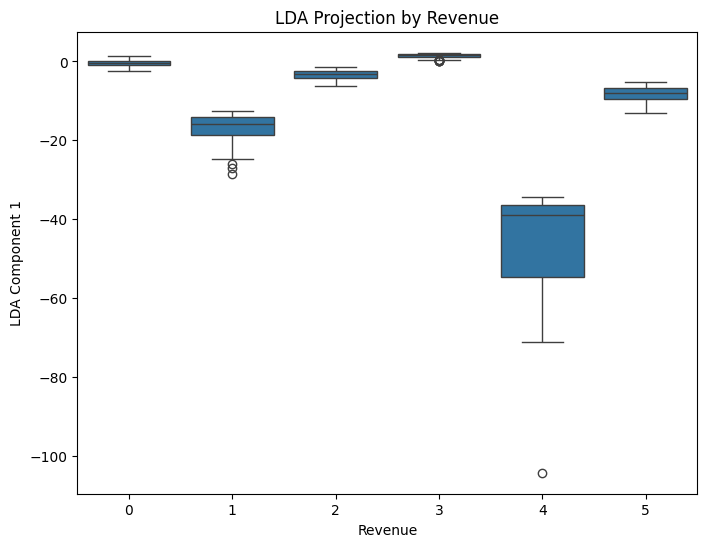

In [94]:
import matplotlib.pyplot as plt
import seaborn as sns

# Project data into the LDA space
lda_transformed = lda.transform(X_selected)

# Create a dataframe for visualization
lda_df = pd.DataFrame({
    'LDA Component 1': lda_transformed[:, 0],
    'Revenue': y
})

# Plot
plt.figure(figsize=(8, 6))
sns.boxplot(x='Revenue', y='LDA Component 1', data=lda_df)
plt.title("LDA Projection by Revenue")
plt.show()


                    Feature  LDA_Coefficient
7                 ExitRates       -14.457529
6               BounceRates         8.219666
10              VisitorType         0.522020
2             Informational         0.036163
0            Administrative         0.034148
8                PageValues         0.005694
11         TotalPagesViewed         0.001813
4            ProductRelated         0.001306
1   Administrative_Duration         0.000466
5   ProductRelated_Duration         0.000300
9           SessionDuration         0.000281
3    Informational_Duration        -0.000130


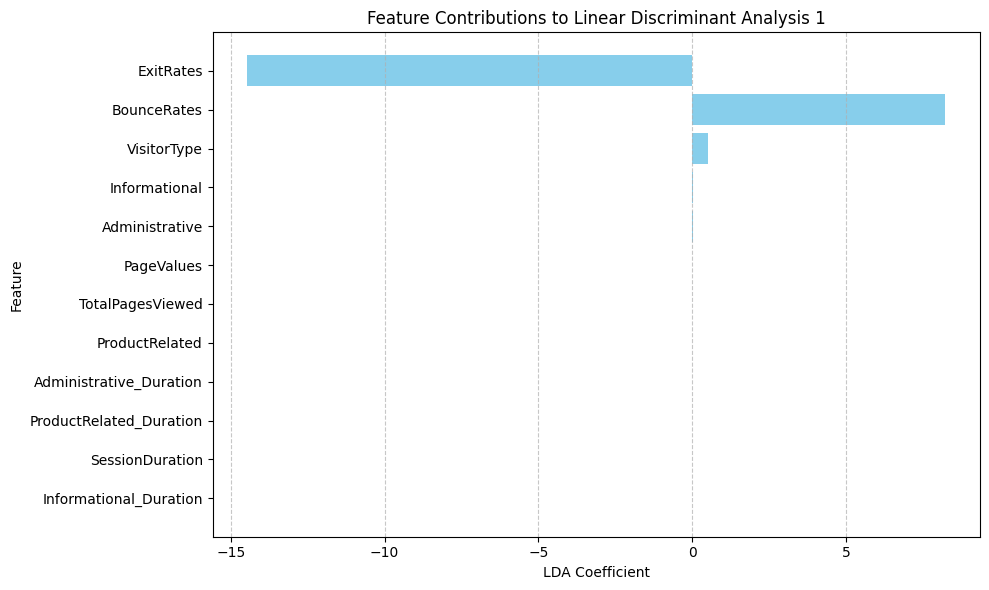

In [95]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Assuming `X` is your feature matrix and `y` is the Revenue target (0/1)
lda = LinearDiscriminantAnalysis()
lda.fit(X, y)

# Extract LDA coefficients for the first discriminant axis (LDA 1)
lda_coefficients = lda.coef_[0]

# Create a DataFrame to pair features with their coefficients
feature_contributions = pd.DataFrame({
    'Feature': X.columns,
    'LDA_Coefficient': lda_coefficients
}).sort_values(by='LDA_Coefficient', key=abs, ascending=False)  # Sort by absolute value

# Display the contributions
print(feature_contributions)

# Plot the feature contributions
plt.figure(figsize=(10, 6))
plt.barh(feature_contributions['Feature'], feature_contributions['LDA_Coefficient'], color='skyblue')
plt.title('Feature Contributions to Linear Discriminant Analysis 1')
plt.xlabel('LDA Coefficient')
plt.ylabel('Feature')
plt.gca().invert_yaxis()  # Invert axis for better readability
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [ ]:
#Based on our understanding we are 

In [ ]:
#Used to identify individual sessions in the columns as an overview
features=['Revenue', 'SessionDuration', 'TotalPagesViewed', 'BounceRates', 'ExitRates', 'PageValues', 'Month', 'OperatingSystems', 'Browser', 'Region', 'TrafficType', 'Weekend', 'VisitorType_New_Visitor', 'VisitorType_Other', 'VisitorType_Returning_Visitor']
#View the values in each Cluster if meaningful*
print(sessions.loc[sessions['Cluster'] == 5, 'PageValues'])

print("\nSample Data Points from Each Cluster:")
for cluster_id in centroid_df.index:
    print(f"\nCluster {cluster_id}:\n", sessions[sessions['Cluster'] == cluster_id].head())

In [37]:
#Seeing how much revenue is attributed to each cluster
print("Cluster 0, % values generated revenue:",sessions[(sessions['Cluster']==0)&(sessions['Revenue']==1)].shape[0]/(sessions['Cluster']==0).sum())
print("Cluster 1, % values generated revenue:",sessions[(sessions['Cluster']==1)&(sessions['Revenue']==1)].shape[0]/(sessions['Cluster']==1).sum())
print("Cluster 2, % values generated revenue:",sessions[(sessions['Cluster']==2)&(sessions['Revenue']==1)].shape[0]/(sessions['Cluster']==2).sum())
print("Cluster 3, % values generated revenue:",sessions[(sessions['Cluster']==3)&(sessions['Revenue']==1)].shape[0]/(sessions['Cluster']==3).sum())
print("Cluster 4, % values generated revenue:",sessions[(sessions['Cluster']==4)&(sessions['Revenue']==1)].shape[0]/(sessions['Cluster']==4).sum())
print("Cluster 5, % values generated revenue:",sessions[(sessions['Cluster']==5)&(sessions['Revenue']==1)].shape[0]/(sessions['Cluster']==5).sum())
#print("Cluster 6, % values generated revenue:",sessions[(sessions['Cluster']==6)&(sessions['Revenue']==1)].shape[0]/(sessions['Cluster']==6).sum())
#print("Cluster 7, % values generated revenue:",sessions[(sessions['Cluster']==7)&(sessions['Revenue']==1)].shape[0]/(sessions['Cluster']==7).sum())

Cluster 0, % values generated revenue: 0.27233115468409586
Cluster 1, % values generated revenue: 0.17479108635097493
Cluster 2, % values generated revenue: 0.23544973544973544
Cluster 3, % values generated revenue: 0.0626500764025322
Cluster 4, % values generated revenue: 0.1910828025477707
Cluster 5, % values generated revenue: 0.2161272627537027
